# Translation model from COCO -> MPII


In [288]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from lovely_numpy import lo
import scipy
import json

In [289]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_val.json', 'r') as f:
    annot_truth_val_set = json.load(f)

with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii_valset.json', 'r') as f:
    annot_pred_coco_val_set = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [290]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  # skip = False
  # for joint_vis in annot_truth[i]['joints_vis']:
  #   if joint_vis == 0:
  #     skip = True
  #     break
  # if skip:
  #   continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (22246, 17, 2)
y shape: (22246, 16, 2)
box scale: (22246,)
box center: (22246, 2)


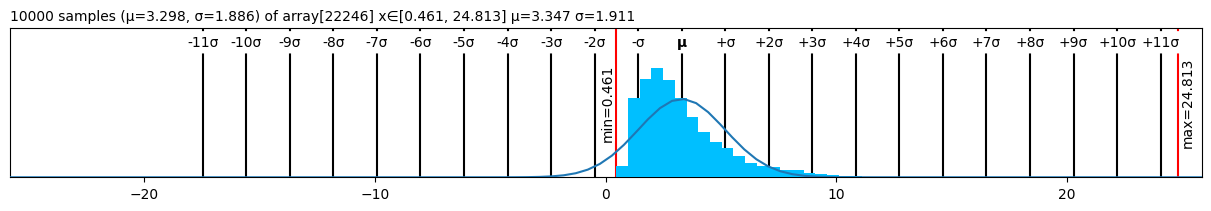

In [291]:
lo(box_scale).plt

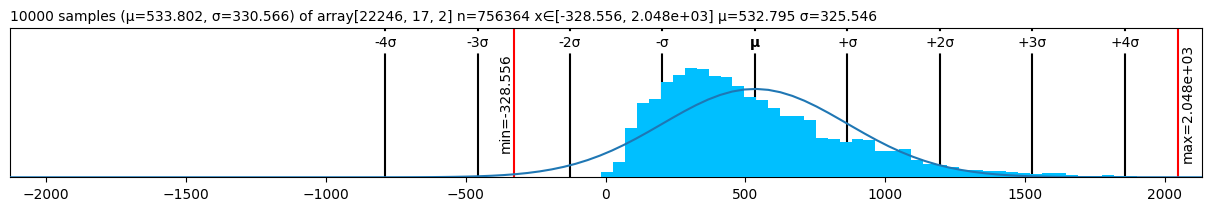

In [292]:
lo(X).plt

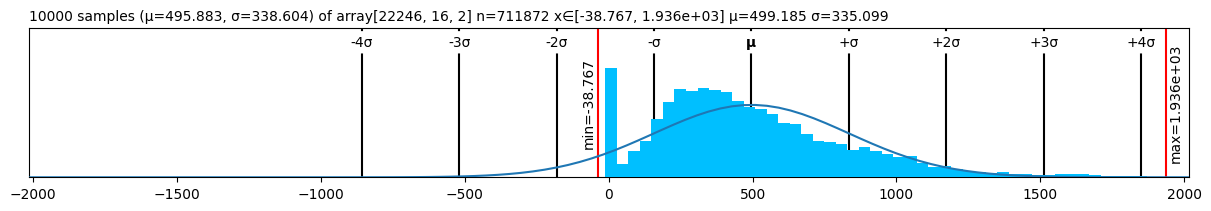

In [293]:
lo(y).plt

How many negative examples are there on each of those (negative doesn't mean anything, except for -1 for 1 where it's non-visible)

In [294]:
print((X < 0).sum())
print(((y < 0) & (y != -1)).sum())
negative_x_mask = np.any(X[:,:,0] <= 0, axis=1) | np.any(X[:,:,1] <= 0, axis=1)

X_clean = X[~negative_x_mask]
y_clean = y[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1)
X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)


425
325
(21768, 17, 2)
(21768, 16, 2)


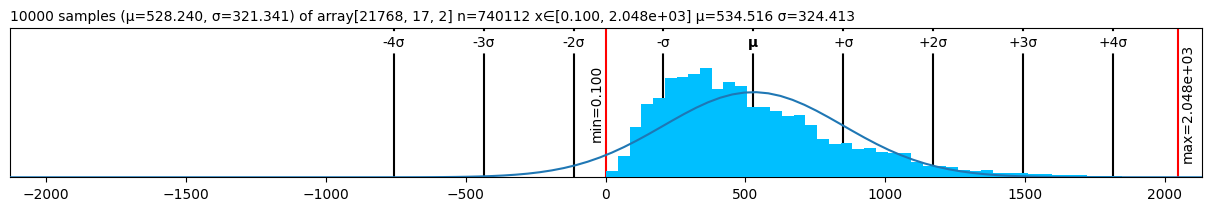

In [295]:
lo(X_clean).plt

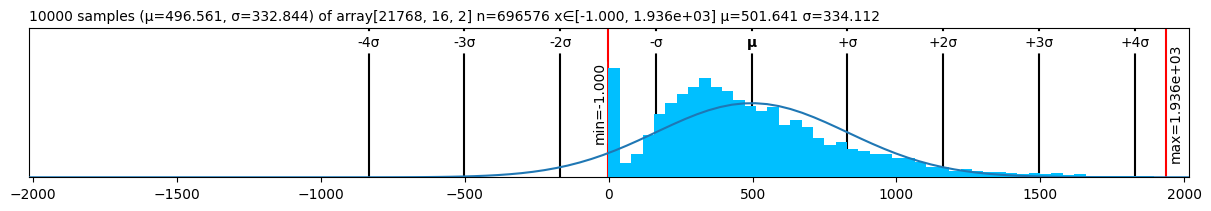

In [296]:
lo(y_clean).plt

## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [297]:
# box_scale = N x 1
# box_center = N x 2
# N x 16 x 2

# needs masking on normalization as well
# to not use not joint visible points
def unnormalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  data = copy.deepcopy(data)

  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data *= bbox_width[:, np.newaxis, :]
  data += bbox_left[:, np.newaxis, :]
  if isinstance(mask, np.ndarray):
    data = data * mask
    # To make back to -1
    data = data + (-1) * (1 - mask)

  return data

def normalize(data, box_center, box_scale, scale_px=200*1.25, mask = None):
  # first width & height, but they are the same
  data = copy.deepcopy(data)
  # bbleft point N x 2
  bbox_left = box_center - ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_right = box_center + ((scale_px * box_scale) / 2)[:, np.newaxis]
  bbox_width = bbox_right - bbox_left

  data -= bbox_left[:, np.newaxis, :] 
  data /= bbox_width[:, np.newaxis, :]
 
  if isinstance(mask, np.ndarray):
      data = data * mask
      # To make back to -1
      data = data + (-1) * (1 - mask)
  return data
  # bbright point
  # return data
X_normalized = normalize(X_clean, box_center=box_center_clean, box_scale=box_scale_clean)
y_normalized = normalize(y_clean, box_center=box_center_clean, box_scale=box_scale_clean, mask=(y_clean != -1))
lo(y_normalized)

array[21768, 16, 2] n=696576 (5.3Mb) x∈[-1.159, 1.230] μ=0.402 σ=0.397

In [298]:
# Check normalize and unnormalize
print((y == unnormalize(normalize(y, box_center=box_center, box_scale=box_scale, mask=(y != -1)), 
                        box_center=box_center, box_scale=box_scale, mask=(y != -1))).sum() != 0)

True


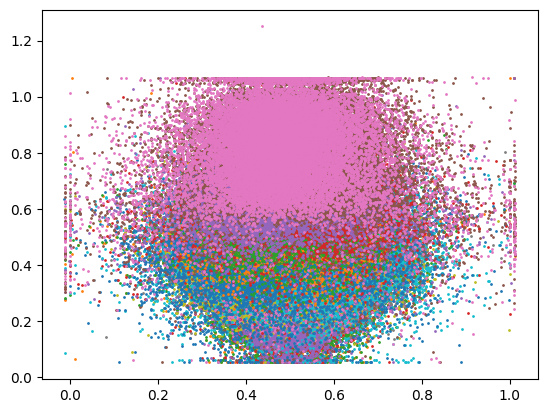

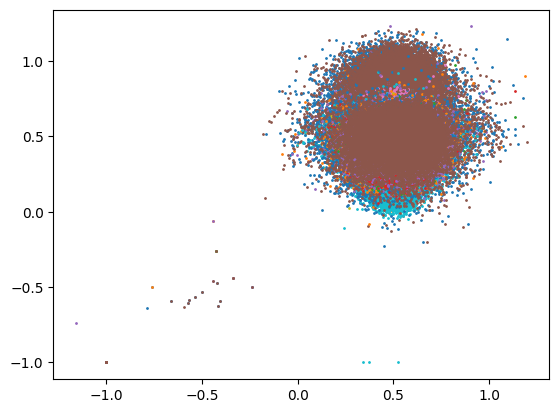

In [299]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Clean normalized

In [300]:
negative_x_mask = np.any(X_normalized[:,:,0] <= 0, axis=1) | np.any(X_normalized[:,:,1] <= 0, axis=1
                        ) | np.any(X_normalized[:,:,0] >= 0.95, axis=1
                        ) | np.any(X_normalized[:,:,1] >= 1.05, axis=1)

X_clean = X_normalized[~negative_x_mask]
y_clean = y_normalized[~negative_x_mask]

negative_y_mask = np.any(
  (y_clean[:,:,0] <= 0) & (y_clean[:,:,0] != -1), axis=1
  ) | np.any((y_clean[:,:,1] <= 0) & (y_clean[:,:,1] != -1), axis=1
  ) | np.any(y_clean[:,:,0] >= 0.95, axis=1
  ) | np.any(y_clean[:,:,1] >= 1.05, axis=1)


X_clean = X_clean[~negative_y_mask]
y_clean = y_clean[~negative_y_mask]

box_scale_clean = box_scale_clean[~negative_x_mask]
box_scale_clean = box_scale_clean[~negative_y_mask]

box_center_clean = box_center_clean[~negative_x_mask]
box_center_clean = box_center_clean[~negative_y_mask]

print(X_clean.shape)
print(y_clean.shape)
X_normalized = X_clean
y_normalized = y_clean


(20554, 17, 2)
(20554, 16, 2)


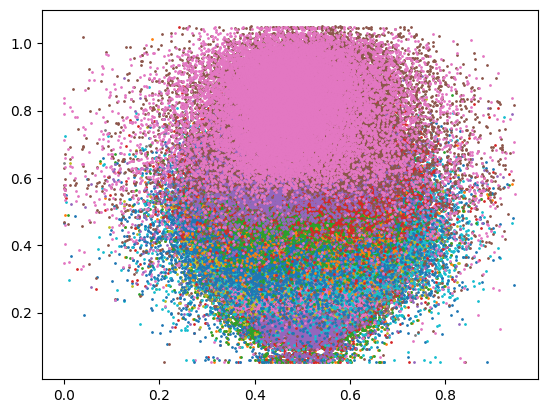

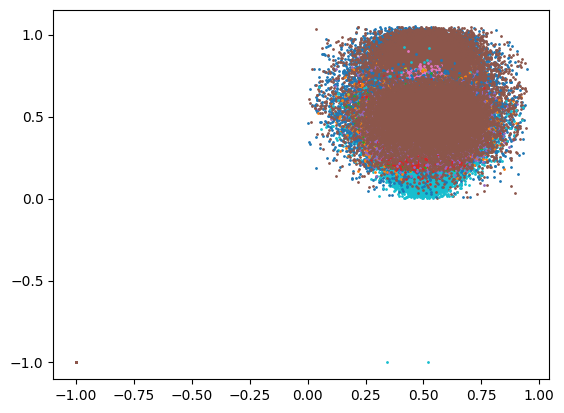

In [301]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

array[20554, 17, 2] n=698836 (5.3Mb) x∈[1.833e-05, 1.050] μ=0.493 σ=0.156


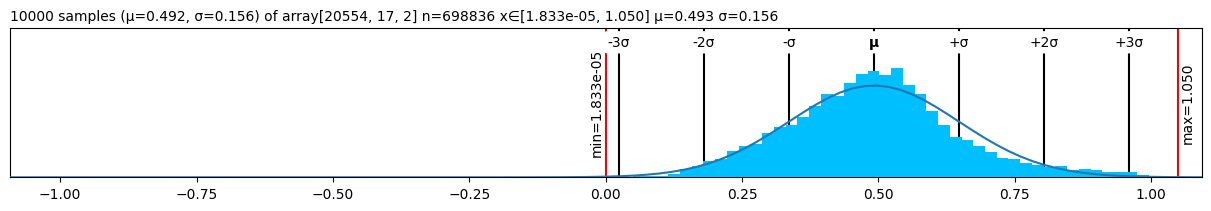

In [302]:
print(lo(X_normalized))
lo(X_normalized).plt

array[20554, 16, 2] n=657728 (5.0Mb) x∈[-1.000, 1.050] μ=0.399 σ=0.400


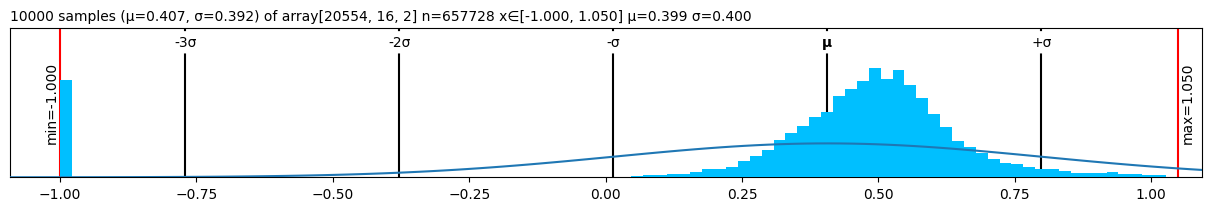

In [303]:
print(lo(y_normalized))
lo(y_normalized).plt

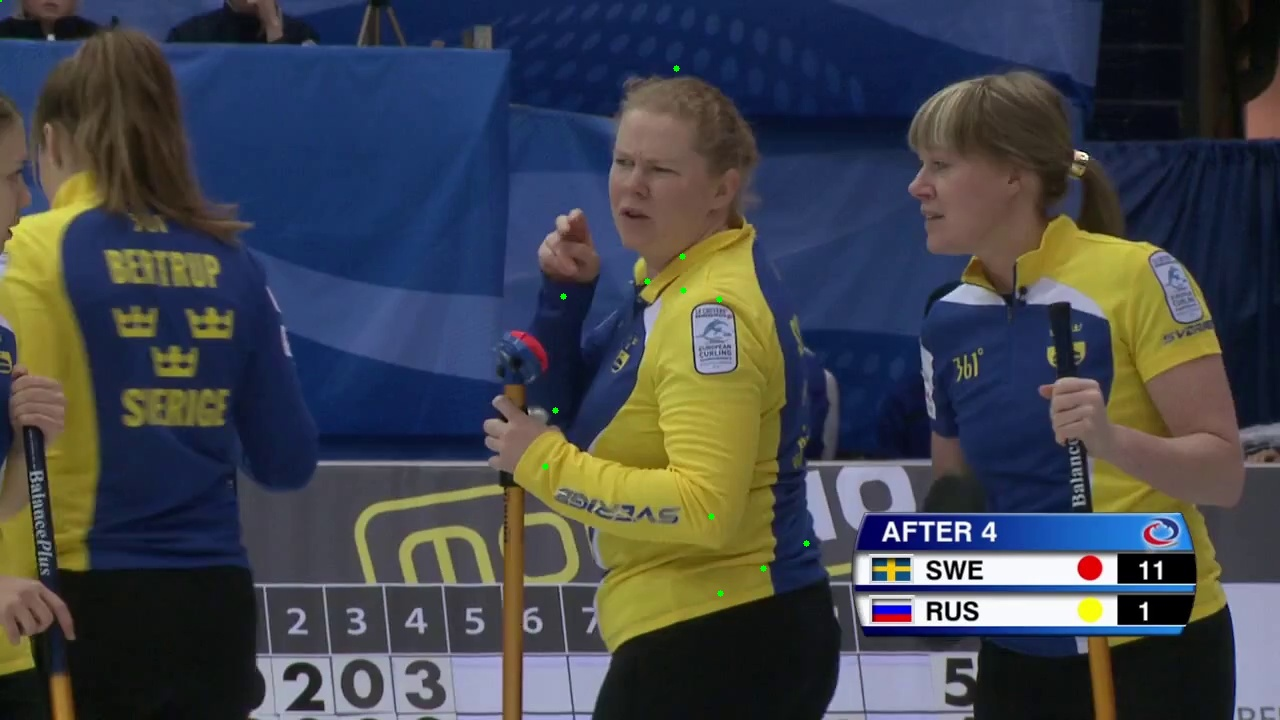

In [304]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'images/tm_results/image_test0.jpg', image)

  display(Image(filename=f'images/tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_truth[index2orig[index[0]]]['joints']
                 )

## Outlier images from coco prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


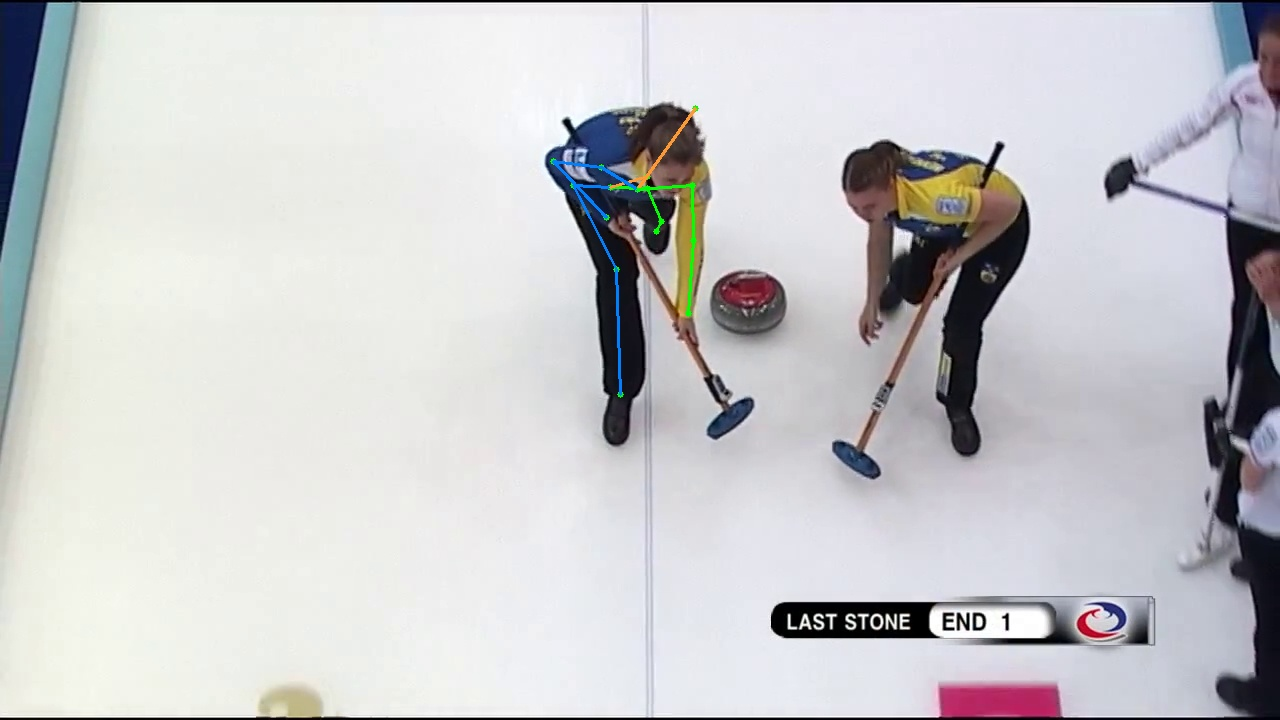

In [305]:
%load_ext autoreload
%autoreload 2

from visualize import visualize_with_keypoints, save_with_keypoints

visualize_with_keypoints(0, annot_truth, annot_truth[0]['joints'])

In [306]:
# N x 17 x 2
index = 0
count = 0
for row in range(y_normalized.shape[0]):
  
  for col in range(y_normalized.shape[1]):
    # Heads
      if y_normalized[row, col, 1] < 0 and y_normalized[row, col, 1] != -1:
        print("heree")
        save_with_keypoints(nth_image=row,
                           annot_truth=annot_truth, 
                           path = f'images/outliers/image{annot_truth[row]["image"]}',
                           keypoints=y[row],
                           skeleton=None,
                           bounding_box=(annot_truth[row]["center"],annot_truth[row]["scale"])
                           )
      index += 1  
# print("On the boundary: ", count)


# PCK Accuracy implementation

In [307]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    # only gt has -1 values
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        # Only use values that are defined
        _gt = gt
        _predict = predict

        mask = torch.all(gt[:, 8:10, 0] != -1, dim=1) 
        _predict = _predict[mask]
        _gt = _gt[mask]

        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask

        distances = torch.norm((_gt - _predict), dim=-1)
        head_length = torch.norm((_gt[:, 8] - _gt[:, 9]), dim=-1) * 0.5 * 0.6
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        correct_classified = distances <= head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
        return percentage.item()

    else:
        _gt = gt
        _predict = predict

        no_head_mask = np.all(gt[:, 8:10, 0] != -1, axis=1) 
        _predict = _predict[no_head_mask]
        _gt = _gt[no_head_mask]
        
        undefined_point_mask = _gt != -1
        _gt = _gt * undefined_point_mask
        _predict = _predict * undefined_point_mask
        
        distances = np.linalg.norm((_gt - _predict), axis=-1)
        # if head_length becomes 0, meaning, it's not defined
        # there'd be no distance lower than zero so still works
        # but we have to remove examples that has no head length
        head_length = np.linalg.norm((_gt[:, 8] - _gt[:, 9]), axis=-1) * 0.5 * 0.6
        correct_classified = distances <= head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = _gt.shape[0] * _gt.shape[1]
        percentage = correct_classified.sum() / (total_keypoints)
    return percentage


calculatePCKh(y_normalized, y_normalized)

1.0

## Define baseline accuracy

In [308]:
# Fake X identity base/ Direct COCO->MPII
def handcraft(coco_x, mpii_y):
  mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
  # Mergeable points merge
  X_mpii_identity = np.ones_like(mpii_y)
  # Merge-able points
  for mpii_key, coco_key in mapping.items():
    X_mpii_identity[:,mpii_key] = coco_x[:,coco_key]
  # pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
  X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
  # thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
  X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
  X_mpii_identity[:,8] = (X_mpii_identity[:,7]+coco_x[:,0])/2
  X_mpii_identity[:,9] = (coco_x[:, 1] + coco_x[:, 2] ) / 2
  return X_mpii_identity

X_transformed_normalized = handcraft(X_normalized, y_normalized)
print(calculatePCKh(X_transformed_normalized, y_normalized))


0.810283471114807


## Split train, val, test

In [315]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64)


Train instance:  16443
Val instance:  4111
torch.Size([16443, 17, 2])
torch.Size([16443, 16, 2])
torch.Size([4111, 17, 2])
torch.Size([4111, 16, 2])


In [316]:
def change_input(input):
  input = 0
for input, target in train_loader:
  print(input)


tensor([[[0.4436, 0.3591],
         [0.4450, 0.3438],
         [0.4471, 0.3443],
         ...,
         [0.4507, 0.6965],
         [0.5721, 0.9846],
         [0.5137, 0.8757]],

        [[0.7163, 0.3612],
         [0.7175, 0.3473],
         [0.7180, 0.3471],
         ...,
         [0.4938, 0.6720],
         [0.5380, 0.6558],
         [0.4493, 0.6582]],

        [[0.4922, 0.2851],
         [0.5019, 0.2717],
         [0.5043, 0.2719],
         ...,
         [0.5021, 0.6785],
         [0.3975, 0.7854],
         [0.4872, 0.7743]],

        ...,

        [[0.3995, 0.1725],
         [0.4019, 0.1585],
         [0.4017, 0.1602],
         ...,
         [0.4391, 0.7084],
         [0.4691, 0.8988],
         [0.3716, 0.8949]],

        [[0.4626, 0.4062],
         [0.4685, 0.3913],
         [0.4662, 0.3914],
         ...,
         [0.5441, 0.7589],
         [0.5724, 0.7522],
         [0.5636, 0.7440]],

        [[0.4896, 0.3476],
         [0.4831, 0.3321],
         [0.4859, 0.3325],
         ...,
 

### Definition of augmentations

In [334]:
def random_shift(data , p=0.1, shift_constant=0.3):
  # N x 16 x 2
  if torch.rand(1).item() < p:
    data = copy.deepcopy(data)
    random_batch_n = torch.randint(0, data.shape[0], (1, )).item()
    random_point = torch.randint(0, 16, (1, )).item()

    # random number between -0.15 to 0.15
    # to choose from gaussian distrubution
    random_shift_x = torch.randn(1).item() * shift_constant
    random_shift_y = torch.randn(1).item() * shift_constant

    data[random_batch_n][random_point][0] += random_shift_x
    data[random_batch_n][random_point][1] += random_shift_y
    return data
  
  return data

# swap_points = [(0,5), (1,4), (2,3), (10,15), (11,14), (12,13)]
def horizontal_flip(data_x, data_y, p=0.1):
  if torch.rand(1).item() < p:
    data_x = copy.deepcopy(data_x)
    data_y = copy.deepcopy(data_y)
    data_x[:,:,0] = 1 - data_x[:,:,0]
    data_y[:,:,0] = 1 - data_y[:,:,0]
    return data_x, data_y
  return data_x, data_y



In [335]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.layers = nn.Sequential(nn.Flatten(),
                                     nn.Linear(2*17,1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 2048),
                                     nn.Tanh(),
                                     nn.Linear(2048, 2048),
                                     nn.Tanh(),
                                     nn.Linear(2048, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 1024),
                                     nn.Tanh(),
                                     nn.Linear(1024, 2*16)
                                     )
    def forward(self, x):
        x = self.layers(x)
        return x.view(-1, 16, 2)

def init_model():
    return TranslatorNN().to(device)

In [336]:
def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.9)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    mask = targets != -1
                    loss = criterion(outputs * mask, targets * mask)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        train_accuracy = 0.0
        for inputs, targets in train_loader:
            # Include data augmentation
            inputs = random_shift(inputs, p=0.4, shift_constant=0.1)   
            inputs,targets = horizontal_flip(inputs, targets, p=0.2)
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = targets != -1
            loss = criterion(outputs * mask, targets * mask)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            with torch.no_grad():
                train_accuracy += (calculatePCKh(outputs, targets))

        epoch_loss = running_loss / len(train_dataset)
        train_accuracy = train_accuracy / (len(train_dataset) / train_loader.batch_size)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                mask = targets != -1
                loss = criterion(outputs * mask, targets * mask)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, TAccuracy: {train_accuracy * 100:.2f}%,  Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [337]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [0.1]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
torch.manual_seed(42)
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []
  model = init_model()
  print(model)
  t_epoch, t_model, t_loss, t_accuracy = train_model(model,lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.4f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



1 [{'lr': 0.1, 'epoch': 200}]
Training for param: {'lr': 0.1, 'epoch': 200}
TranslatorNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=34, out_features=1024, bias=True)
    (2): Tanh()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): Tanh()
    (5): Linear(in_features=1024, out_features=2048, bias=True)
    (6): Tanh()
    (7): Linear(in_features=2048, out_features=2048, bias=True)
    (8): Tanh()
    (9): Linear(in_features=2048, out_features=1024, bias=True)
    (10): Tanh()
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): Tanh()
    (13): Linear(in_features=1024, out_features=1024, bias=True)
    (14): Tanh()
    (15): Linear(in_features=1024, out_features=1024, bias=True)
    (16): Tanh()
    (17): Linear(in_features=1024, out_features=1024, bias=True)
    (18): Tanh()
    (19): Linear(in_features=1024, out_features=32, bias=True)
  )
)
Epoch [0/200], Val Loss: 0.464719
Epoch [1/200],

In [321]:
print(best_params)
print(best_epoch)
print(best_accuracy)

{'lr': 0.1, 'epoch': 200}
167
0.8849368316939903


## Eval on test set

In [ ]:
torch.save(best_model.state_dict(), 'models/best_translation_model_with_augmentation.pth')

In [ ]:
def load_model_if_not_defined():
    try:
        best_model
    except NameError:
        # Load your model here
        best_model = TranslatorNN()
        best_model.load_state_dict(torch.load('./models/best_translation_model3.pth', map_location=device))
        return best_model
best_model = load_model_if_not_defined()

In [ ]:
best_model.to(device)

TranslatorNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=34, out_features=1024, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
  (act2): Tanh()
  (hidden3): Linear(in_features=1024, out_features=512, bias=True)
  (act3): Tanh()
  (hidden4): Linear(in_features=512, out_features=512, bias=True)
  (act4): Tanh()
  (hidden5): Linear(in_features=512, out_features=512, bias=True)
  (act5): Tanh()
  (output): Linear(in_features=512, out_features=32, bias=True)
)

In [322]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

X_test = list()
y_test = list()
test_box_scale = list()
test_box_center = list()

for i in range(len(annot_truth_val_set)):
  X_test.append(annot_pred_coco_val_set['annotations'][i]['joints'])
  y_test.append(annot_truth_val_set[i]['joints'])
  test_box_scale.append(annot_truth_val_set[i]['scale'])
  test_box_center.append(annot_truth_val_set[i]['center'])

X_test = np.array(X_test)
y_test = np.array(y_test)
test_box_scale = np.array(test_box_scale)
test_box_center = np.array(test_box_center)

print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)



X_test:  (2958, 17, 2)
y_test:  (2958, 16, 2)


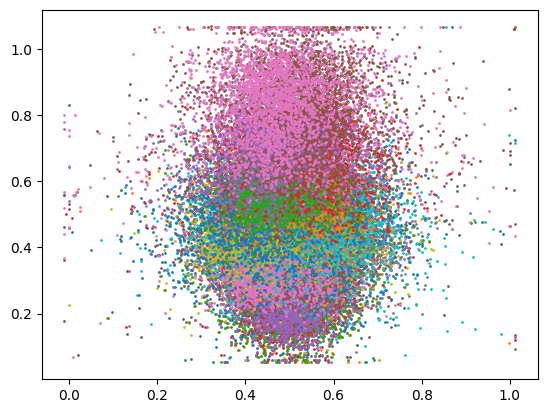

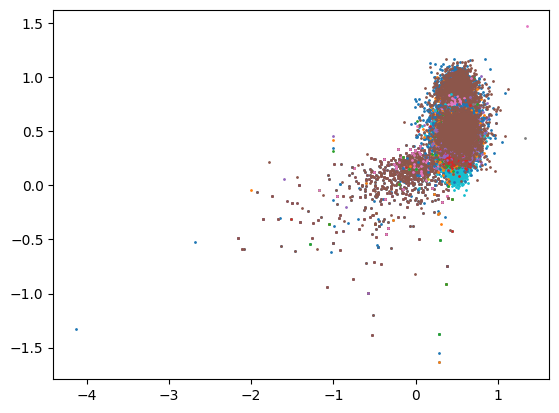

In [323]:
X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
y_test_normalized = normalize(y_test, test_box_center, test_box_scale, scale_px=200*1.25, mask = (y_test!=1))

for i in range(17):
  plt.scatter(X_test_normalized[:, i, 0],X_test_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_test_normalized[:, i, 0],y_test_normalized[:, i, 1], s=1)
plt.show()

In [324]:
best_model.eval()

with torch.no_grad():
  X_test_normalized = normalize(X_test, test_box_center, test_box_scale)
  X_test_feed_in = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)

  prediction = best_model(X_test_feed_in) 
print("Pred: ", prediction.shape)

Pred:  torch.Size([2958, 16, 2])


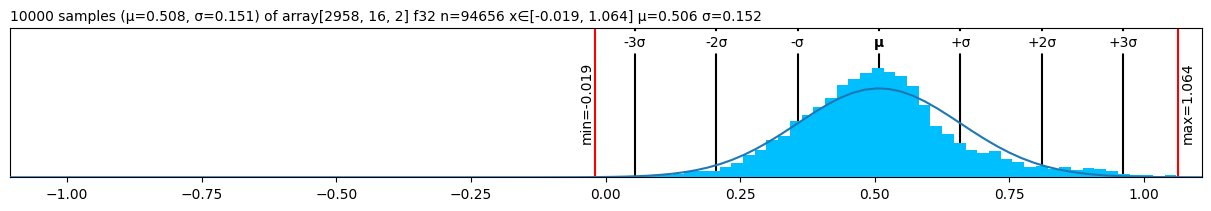

In [ ]:
lo(np.array(prediction.cpu())).plt

In [325]:
gt_dict = scipy.io.loadmat(ROOT_FOLDER+'/data/MPII_COCO/annotations/mpii_gt_val.mat')

dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

pos_pred_src = unnormalize(prediction.cpu(), 
                           box_center=test_box_center,
                           box_scale=test_box_scale,
                           )
pos_pred_src = np.transpose(pos_pred_src.cpu(), [1, 2, 0])

head = np.where(dataset_joints == 'head')[1][0]
lsho = np.where(dataset_joints == 'lsho')[1][0]
lelb = np.where(dataset_joints == 'lelb')[1][0]
lwri = np.where(dataset_joints == 'lwri')[1][0]
lhip = np.where(dataset_joints == 'lhip')[1][0]
lkne = np.where(dataset_joints == 'lkne')[1][0]
lank = np.where(dataset_joints == 'lank')[1][0]

rsho = np.where(dataset_joints == 'rsho')[1][0]
relb = np.where(dataset_joints == 'relb')[1][0]
rwri = np.where(dataset_joints == 'rwri')[1][0]
rkne = np.where(dataset_joints == 'rkne')[1][0]
rank = np.where(dataset_joints == 'rank')[1][0]
rhip = np.where(dataset_joints == 'rhip')[1][0]

SC_BIAS = 0.6
threshold = 0.5

jnt_visible = 1 - jnt_missing
uv_error = pos_pred_src - pos_gt_src

uv_err = np.linalg.norm(uv_error, axis=1)
headsizes = headboxes_src[1, :, :] - headboxes_src[0, :, :]
headsizes = np.linalg.norm(headsizes, axis=0)
headsizes *= SC_BIAS
scale = headsizes * np.ones((len(uv_err), 1), dtype=np.float32)
scaled_uv_err = uv_err / scale
scaled_uv_err = scaled_uv_err * jnt_visible
jnt_count = np.sum(jnt_visible, axis=1)
less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
PCKh = 100. * np.sum(less_than_threshold, axis=1) / jnt_count

# save
rng = np.arange(0, 0.5 + 0.01, 0.01)
pckAll = np.zeros((len(rng), 16), dtype=np.float32)

for r, threshold in enumerate(rng):
    less_than_threshold = (scaled_uv_err <= threshold) * jnt_visible
    pckAll[r, :] = 100. * np.sum(
        less_than_threshold, axis=1) / jnt_count

PCKh = np.ma.array(PCKh, mask=False)
print("PCKh Thorax: ", PCKh[6])
print("PCKh Pelvis: ", PCKh[7])
PCKh.mask[6:8] = True

jnt_count = np.ma.array(jnt_count, mask=False)
jnt_count.mask[6:8] = True
jnt_ratio = jnt_count / np.sum(jnt_count).astype(np.float64)

name_value = [('Head', PCKh[head]),
              ('Shoulder', 0.5 * (PCKh[lsho] + PCKh[rsho])),
              ('Elbow', 0.5 * (PCKh[lelb] + PCKh[relb])),
              ('Wrist', 0.5 * (PCKh[lwri] + PCKh[rwri])),
              ('Hip', 0.5 * (PCKh[lhip] + PCKh[rhip])),
              ('Knee', 0.5 * (PCKh[lkne] + PCKh[rkne])),
              ('Ankle', 0.5 * (PCKh[lank] + PCKh[rank])),
              ('Thorax', PCKh[7]),
              ('Pelvis', PCKh[6]),
              ('Upper neck', PCKh[8]),
              ('PCKh', np.sum(PCKh * jnt_ratio)),
              ('PCKh@0.1', np.sum(pckAll[10, :] * jnt_ratio))]
for val in name_value:
    print(f'{val[0]}: {val[1]:.2f}%')




PCKh Thorax:  91.55663655316192
PCKh Pelvis:  97.71487039563438
Head: 93.35%
Shoulder: 95.69%
Elbow: 89.47%
Wrist: 84.58%
Hip: 87.74%
Knee: 85.67%
Ankle: 82.14%
Thorax: --%
Pelvis: --%
Upper neck: 96.79%
PCKh: 88.98%
PCKh@0.1: 28.85%


/tmp/ipykernel_1674/3963776908.py:77: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f'{val[0]}: {val[1]:.2f}%')


In [ ]:
pos_gt_src.shape

(16, 2, 2958)

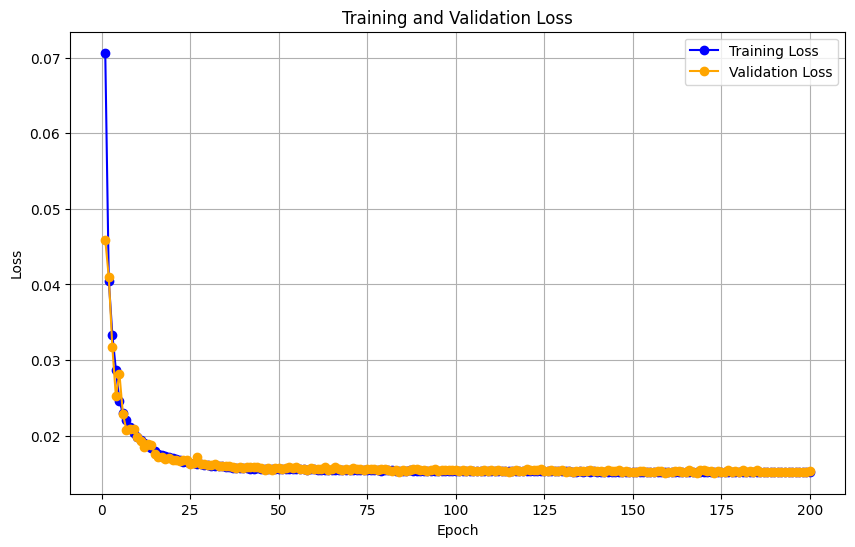

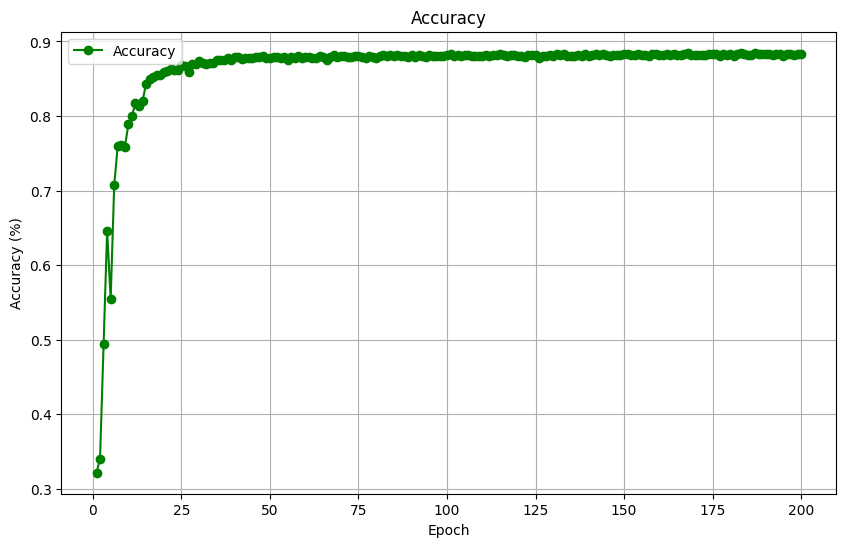

In [326]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Display some images from translation model

In [ ]:
import cv2
from IPython.display import Image, display
from info import MPII_INFO
dataset_info = MPII_INFO()

In [ ]:
# dataset_info['skeleton_info']
kps_name2index = {dataset_info['keypoint_info'][key]['name']:key for key in dataset_info['keypoint_info'] }
print(kps_name2index)


{'right_ankle': 0, 'right_knee': 1, 'right_hip': 2, 'left_hip': 3, 'left_knee': 4, 'left_ankle': 5, 'pelvis': 6, 'thorax': 7, 'upper_neck': 8, 'head_top': 9, 'right_wrist': 10, 'right_elbow': 11, 'right_shoulder': 12, 'left_shoulder': 13, 'left_elbow': 14, 'left_wrist': 15}


## Saving some translated images for future references
- green is the prediction and red is the gt

In [ ]:
from visualize import save_with_multiple_keypoints
# N x 17 x 2
y_preds_orig = unnormalize(prediction.cpu(), test_box_center, test_box_scale)

index = 0
count = 0


random_numbers = np.random.randint(0, 2958, size=10)

for rand_ind in random_numbers:
   save_with_multiple_keypoints(nth_image=rand_ind,
                           annot_truth=annot_truth_val_set, 
                           path = f'images/best_results/image{annot_truth_val_set[rand_ind]["image"]}',
                           keypoints=X_test[rand_ind],
                           skeleton=None,
                           bounding_box=(annot_truth_val_set[rand_ind]["center"],annot_truth_val_set[rand_ind]["scale"]),
                           keypoints1=y_preds_orig[rand_ind],
                           keypoints2=annot_truth_val_set[rand_ind]["joints"],
                           label1="COCO Pred",
                           label2="COCO->MPII and GT"
                           )



023453087.jpg
bbleft: (171, -167)
bbright: (1426, 1087)
000988787.jpg
bbleft: (314, 212)
bbright: (1001, 899)
058301865.jpg
bbleft: (481, -61)
bbright: (1494, 951)
090626579.jpg
bbleft: (173, -119)
bbright: (766, 473)
006584216.jpg
bbleft: (607, 176)
bbright: (974, 543)
016928621.jpg
bbleft: (249, -293)
bbright: (2068, 1525)
014821911.jpg
bbleft: (-41, -141)
bbright: (873, 773)
006203676.jpg
bbleft: (238, -134)
bbright: (1145, 772)
051726906.jpg
bbleft: (34, -155)
bbright: (749, 559)
077812566.jpg
bbleft: (171, -178)
bbright: (1306, 956)


# Try building simple regressors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  10790
Val instance:  3597
Test instance:  6167
torch.Size([10790, 17, 2])
torch.Size([10790, 16, 2])
torch.Size([3597, 17, 2])
torch.Size([3597, 16, 2])


In [ ]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)
y_pred = []
for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  y_pred.append(pred)
  print(f'Error {point}: {error}')


(10790, 34)
(3597, 34)
y_val:  (3597, 16, 2)
Error 0: 0.2693443298339844
Error 1: 0.19387255609035492
Error 2: 0.04665512964129448
Error 3: 0.04712916538119316
Error 4: 0.20338869094848633
Error 5: 0.2828012704849243
Error 6: 0.05211151763796806
Error 7: 0.00992658268660307
Error 8: 0.009803159162402153
Error 9: 0.009477516636252403
Error 10: 0.021291257813572884
Error 11: 0.009583099745213985
Error 12: 0.003711329074576497
Error 13: 0.007394340354949236
Error 14: 0.011794552206993103
Error 15: 0.027829082682728767


In [ ]:
y_pred = np.array(y_pred)
y_pred.transpose(1,0,2).shape
# 16 N 2
calculatePCKh(y_pred.transpose(1,0,2), y_val)

0.5455935501807061

In [ ]:
y_train.shape

(10790, 16, 2)

In [ ]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

(3597, 17, 2)
(3597, 16, 2)


[5.7771764 6.6435676]
[4.1824436 5.1991277]
[ 6.9651403 18.852098 ]
